## MC simulations of fluids

In [83]:
import matplotlib.pyplot as plt

import numpy as np
from itertools import product

from ipywidgets import interact, interactive
import plotly.express as px
import plotly.graph_objects as go
from numba import jit, njit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    from google.colab import output
    output.enable_custom_widget_manager()
    print('All good to go')
except:
    print('Okay we are not in Colab just proceed as if nothing happened')

Okay we are not in Colab just proceed as if nothing happened


## LJ model of a simple fluids, noble gases


**Check out reference values of [LJ fluid properties tabulated by NIST](https://www.nist.gov/mml/csd/chemical-informatics-research-group/lennard-jones-fluid-properties)**



### Initialize the system, and watch out for clashes!

- Density and unit cell number can be used to fully specify a lattice packed with LJ particles 

In [1]:
def IC_pos(rho=0.88, N_cell=3):
    """
    Create a lattice of Lennard-Jones particles initially placed in a cubic FCC lattice.

    Parameters:
    rho (float, optional): Number density of particles. Defaults to 0.88.
    N_cell (int, optional): Number of unit cells in one direction. Defaults to 3.

    Returns:
    np.array: Array of particle positions.
    float: Length of the simulation box.
    int: Total number of particles.
    """
    from itertools import product
    
    N = 4 * N_cell ** 3  # Total number of particles in the system
    L = (N / rho) ** (1 / 3)  # Length of the simulation box
    L_cell = L / N_cell  # Length of a unit cell

    # Generate positions within the unit cell
    base_positions = np.array([[0, 0, 0],
                               [0, 0.5, 0.5],
                               [0.5, 0, 0.5],
                               [0.5, 0.5, 0]])

    # Create lattice by translating the base positions
    pos = np.array([base + np.array([x, y, z]) for x, y, z in product(range(N_cell), repeat=3)
                    for base in base_positions])

    # Scale positions to the size of the unit cell
    pos *= L_cell

    return pos, L, N

In [84]:
def cell_plotter(rho=0.88, N_cell=3):
    """
    Generate and plot a 3D scatter plot of particles in a simulation box.

    Parameters:
    rho (float): Density of particles.
    N_cell (int): Number of cells along one dimension.
    """
    pos, L, N = IC_pos(rho=rho, N_cell=N_cell)  # Get initial conditions
    fig = go.Figure(data=[go.Scatter3d(
        x=pos[:,0],
        y=pos[:,1],
        z=pos[:,2],
        mode='markers',
        marker=dict(
            size=5,  # Adjust size of markers
            opacity=0.5  # Adjust opacity of markers
        )
    )])

    # Update plot layout
    fig.update_layout(
        title=f"3D Plot of Particles in a Box with Density {rho} and {N} Particles",
        width=700,
        height=700,
        scene=dict(
            xaxis_title='X Coordinate',
            yaxis_title='Y Coordinate',
            zaxis_title='Z Coordinate',
            xaxis=dict(range=[0, L]),
            yaxis=dict(range=[0, L]),
            zaxis=dict(range=[0, L])
        )
    )

    fig.show()

In [85]:
interactive(cell_plotter, rho=(0.5, 1.5, 0.1), N_cell=(1, 10, 1))

interactive(children=(FloatSlider(value=0.88, description='rho', max=1.5, min=0.5), IntSlider(value=3, descrip…

### [Periodic Boundary conditions and minimum image criterion](https://en.wikipedia.org/wiki/Periodic_boundary_conditions)

- If a particle leaves the box, it re-enters at the opposite side.
- What should be the distance between partiles? There is some mbiguity because distance between atoms may now include crossing the system boundary and re-entering. This is identical to introducing copies of the particles around the simulation box. We adopt **minimum image convention** by choosing the shortest distance possible

![](./pbc_fig1.gif)

![](./pbc_fig2.gif)

- By adopting minimum image convention we consider the closest of all 'image partners' (plus the original) of every atom for calculating interaction. The animation below highlights the image partners of the two red atoms that are closest to the green atom. 

- To minimize distance between points we evaluate distances along x, y and z dimension and choose the smallest possible one. 


In [41]:
def pbc_basic(x, L):
  '''For a box centered at the origin. This pbc function for wrapping positions of particles back into the into the box. 
  This function should also be used for dx displacements to obey minimum image criterion. 
  '''
    
  if   x >=  L/2: x -= L  

  elif x <= -L/2: x += L

  return x


@njit
def pbc_wrap(r_vec, L):
    """
    Apply periodic boundary conditions using a vectorized approach to wrap a position vector back into a simulation box.
    It is assumed that box is centered at the origin with coordinate bound by -L/2, L/2
    
    Parameters:
    r_vec (np.array): A numpy array representing the displacement vector [x, y, z].
    L_box (float): The length of one side of the cubic simulation box centered at the origin.

    Returns:
    np.array: The wrapped position vector within the simulation box centered at the origin.
    """
   
    # Vectorized operation to wrap the vector into the box centered at the origin
    r_vec = (r_vec + L/2) % L - L/2

    return r_vec

**Visualize coordinate wrapping**

In [60]:
@interact(x=(-15, 15), L=10)
def viz_wrap(x, L):

    plt.hlines(-L/2, -L, L, color='red')
    plt.hlines(L/2, -L, L, color='red')
    
    x_wrap = pbc_wrap(x, L) #pbc_basic(x, L)
    plt.plot(x, x_wrap, 'o')
    plt.xlabel('original x')
    plt.ylabel('wrapped x')
    plt.ylim(-L, L)
    plt.show()

interactive(children=(IntSlider(value=0, description='x', max=15, min=-15), IntSlider(value=10, description='L…

### Computing pairwise distances and energies

In [61]:
@njit
def getE_tot(pos, L, trunc, sig=1, eps=1):
    """
    Compute the total potential energy of a Lennard-Jones fluid by summing pairwise interactions.
    
    Parameters:
    pos (array): Positions of particles in the system.
    L (float): Length of the cubic simulation box.
    trunc (float): Cutoff radius for interactions.
    sig (float, optional): Sigma parameter of the LJ potential. Defaults to 1.
    eps (float, optional): Epsilon parameter of the LJ potential. Defaults to 1.
    
    Returns:
    float: Total potential energy of the system.
    list: List of squared distances for each particle pair.
    """
    N = len(pos)
    energy = 0.0
    r_sq_list = []

    for i in range(N - 1):
        for j in range(i + 1, N):
            r_vec = pbc_wrap(pos[i] - pos[j], L)
            r_sq = np.sum(r_vec**2)

            if r_sq <= trunc**2:
                inv_r_sq = sig**2 / r_sq
                energy += 4 * eps * (inv_r_sq**3 - inv_r_sq**1.5)
            r_sq_list.append(r_sq)

    return energy, r_sq_list

@njit
def E_disp(pos, L, trunc, j, r_j, sig=1, eps=1):
    """
    Compute the change in energy resulting from displacing particle j to position r_j.
    
    Parameters:
    pos (array): Current positions of all particles.
    L (float): Length of the cubic simulation box.
    trunc (float): Cutoff radius for interactions.
    j (int): Index of the particle being displaced.
    r_j (array): New position of the displaced particle.
    sig (float, optional): Sigma parameter of the LJ potential. Defaults to 1.
    eps (float, optional): Epsilon parameter of the LJ potential. Defaults to 1.
    
    Returns:
    float: Energy of particle j at new position due to interactions with other particles.
    """
    N = len(pos)
    energy = 0.0

    for i in range(N):
        if i != j:
            r_vec = pbc_wrap(pos[i] - r_j, L)
            r_sq = np.sum(r_vec**2)

            if r_sq <= trunc**2:
                inv_r_sq = sig**2 / r_sq
                energy += 4 * eps * (inv_r_sq**3 - inv_r_sq**1.5)

    return energy

### MC engine for LJ fluid in 3D (NVT ensemble)
Now that the main helper functions are set up we can put together a main Monte Carlo engine that loops through randomly selected particles and attemps their displacement via Metropolis Criterion. 

In [80]:
@njit
def run_MC_LJ(pos, L, T, trunc=4, disp=0.5, steps=10000, freq=100):
    """
    Run a Monte Carlo simulation for a Lennard-Jones fluid.

    Parameters:
    pos (array): Initial positions of particles.
    rho (float): Number density of particles.
    T (float): Temperature of the system.
    trunc (float, optional): Cutoff radius for interactions. Defaults to 4.
    disp (float, optional): Maximum displacement of particles in one step. Defaults to 0.5.
    steps (int, optional): Number of Monte Carlo steps. Defaults to 10000.
    freq (int, optional): Frequency of recording data. Defaults to 1000.

    Returns:
    list: List of configurations at each recorded step.
    list: List of total energies at each recorded step.
    list: List of histograms of squared distances at each recorded step.
    """
    
    N = len(pos)
    E_tot, r_sq_list = getE_tot(pos, L, trunc)
    
    es = [E_tot]
    hists = []
    confs = [pos.copy()]

    for step in range(steps):
        # Select a particle randomly
        j = np.random.randint(N)
        
        # Calculate a random displacement
        delta = np.random.uniform(-disp, disp, size=3)
        
        # New position considering periodic boundary conditions
        r_j_new = pbc_wrap(pos[j] + delta, L)

        # Energy change due to displacement
        dE = E_disp(pos, L, trunc, j, r_j_new) - E_disp(pos, L, trunc, j, pos[j])

        # Metropolis acceptance criterion
        if np.exp(-dE / T) > np.random.rand():
            pos[j] = r_j_new
        
        # Data collection at a specified frequency
        if step % freq == 0:
            E_tot, r_sq_list = getE_tot(pos, L, trunc)
            H, _ = np.histogram(np.array(r_sq_list), bins=30, range=(0, L / 2))
            hists.append(H)
            es.append(E_tot)
            confs.append(pos.copy())

    return confs, es, hists

### Running MCMC simulation on LJ system

In [98]:
rho=0.88
pos, L, N = IC_pos(rho, N_cell=3)

params = dict(L = L,
              T = 0.2, 
              steps=1000000, 
              trunc=4, 
              disp=0.5,
              freq=100)

In [99]:
#%time 
confs, es, hists = run_MC_LJ(pos, **params)

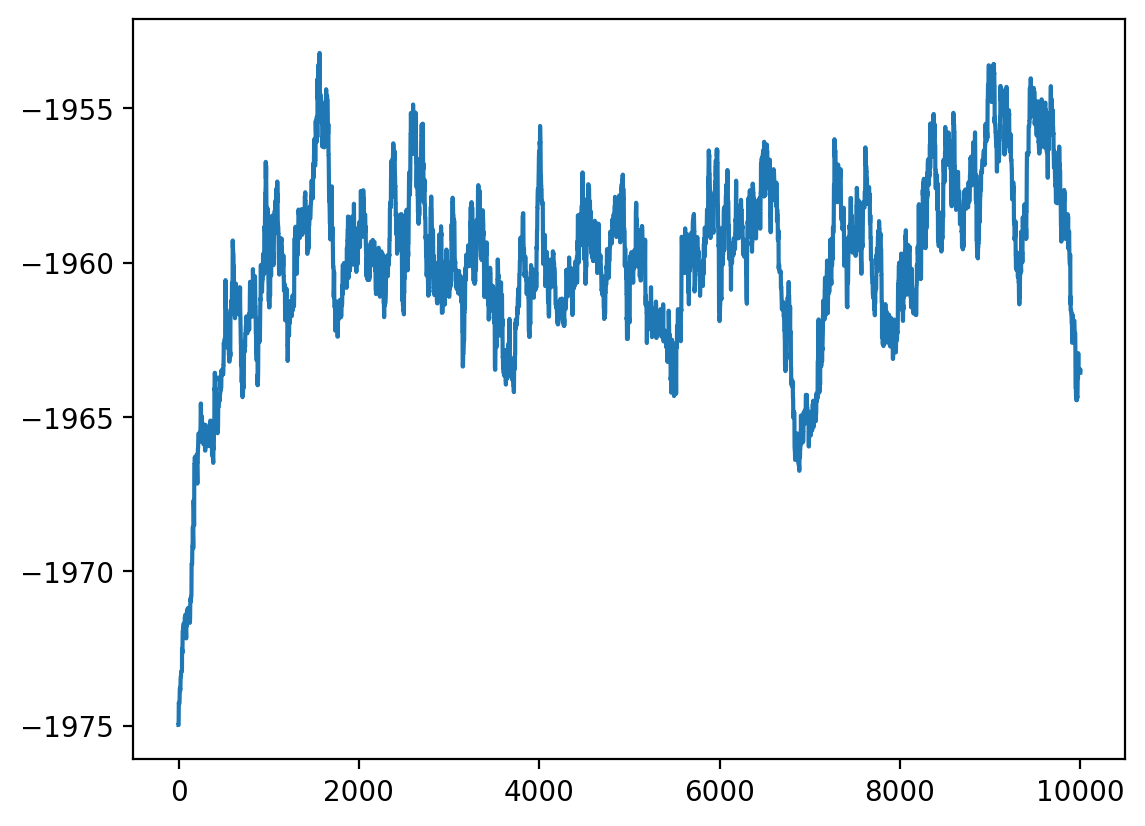

In [100]:
plt.plot(es) 

In [91]:
n = params['steps']//params['freq']

@interact(i=(0, n-1))
def viz_sim_lj(i=0):

  fig = go.Figure(data=[go.Scatter3d(
        x=pos[i,0],
        y=pos[i,1],
        z=pos[i,2],
        mode='markers',
        marker=dict(
            size=5,  # Adjust size of markers
            opacity=0.5  # Adjust opacity of markers
        )
    )])

  return fig

interactive(children=(IntSlider(value=0, description='i', max=9999), Output()), _dom_classes=('widget-interact…

Text(0, 0.5, '$g(r)$')

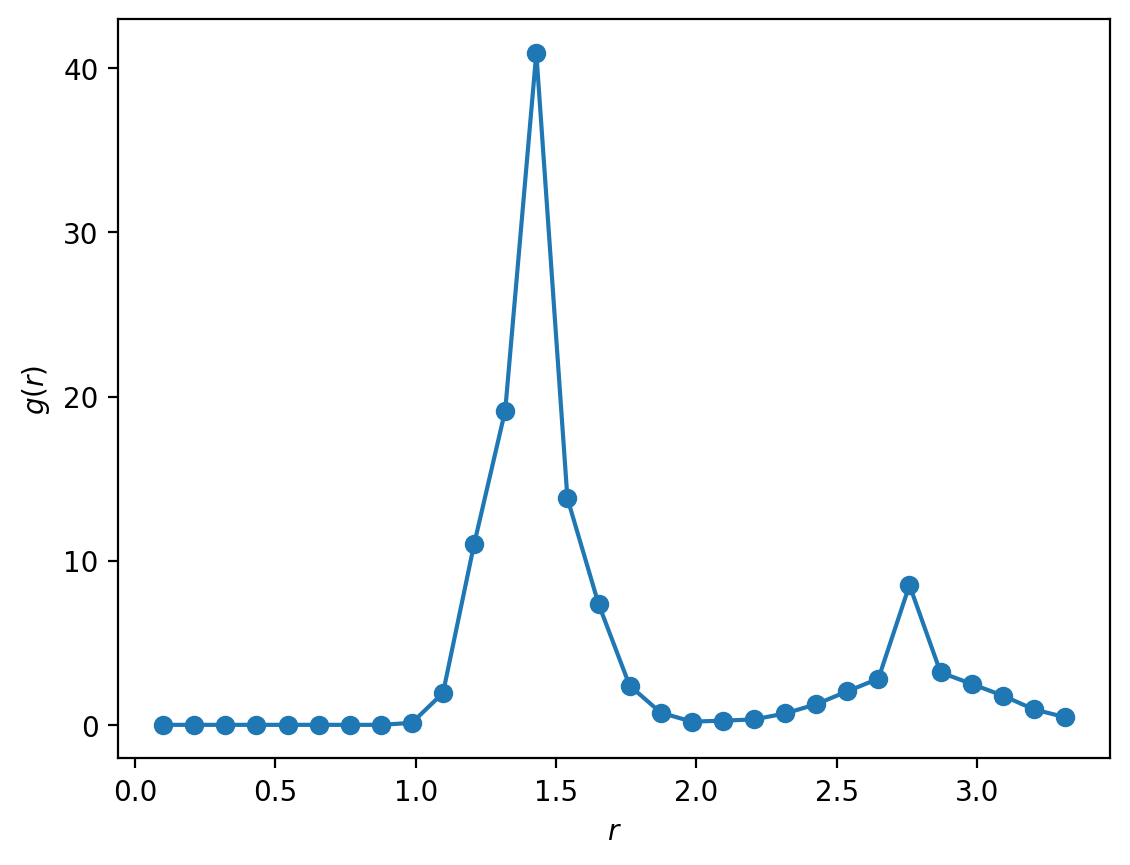

In [97]:
r = np.linspace(0.1, L / 2, 30)

pair_correlation = np.mean(hists, axis=0) / (4 * np.pi * rho * r)

plt.plot(r, pair_correlation, '-o') 
plt.xlabel(r'$r$')  
plt.ylabel(r'$g(r)$')

### Problems

**1. Implementing PBC and minimal image convention methods outlined on  [Wikipeida](https://en.wikipedia.org/wiki/Periodic_boundary_conditions) in python.**

- Write a few functions that take positions of N particles in 3D with shape (N,3) return new coordinates and all inter-particle distances. 
> You can generate random positions using ```np.random``` make sure you have enough particles outside of box to test your functions. 
> Try implementing your functions using numpy methods instead of having multiple for loops. That way your functions will run singnificantly faster.


```python
def pbc_dists(pos, L):

    ...
    
    return pos, dists

```

 - Evaluate distribution of energies of your random positions before and after applying pbc_dists.
 
 
**2. Simulating 2D random walk with PBCs.**

 - Create a sequence of images or better yet an animation showing the temporal evolution of 10 independent random walkers in 100 by 100 square. Consult the random walk section and notebooks to refresh your memory of random walk simulations.
 - Calculate the root mean square displacement from the origin and show how it scales with time (steps)!
  
 
**2. Run MC simulations of LJ fluid at several temperatures to identify critical temperature.**

 - At each temperature evaluate heat capacity and RDFs.
 - Plot how energy, heat capacity and RDF change as a function of temperature.
 - Study dependence on sampling efficiency on magnitude of particle displacement.